# Overview of Derivative Free Optimization Methods

Learning Objectives:
1. Define the concepts of Grid and Random Hyper-parameter search.
2. Use Grid and Random search to optimize hyper-parameters of a model.
2. Distinguish when Randomized Search is much better than grid search.
3. Describe how Global Optimization procedures such as Bayesian Optimization work.
4. Recognize Why none of those at all work in High Dimensions, and *actually* you should use something else entirely if possible, like Reversible Learning or factoring the hyper-parameters into problem (i.e., Bayesian methods)

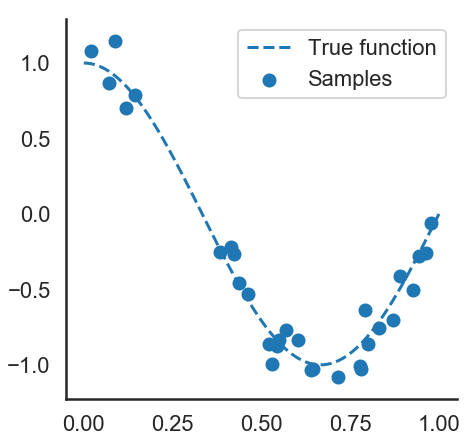

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style("white")
pal = sns.color_palette("Paired")
cmap = sns.blend_palette(pal,as_cmap=True)

np.random.seed(0)

n_samples = 30

# True Function we want to estimate
true_fun = lambda X: np.cos(1.5 * np.pi * X)

# Noisy Samples from the true function
X = np.sort(np.random.rand(n_samples))[:, np.newaxis]
y = true_fun(X) + np.random.randn(n_samples)[:, np.newaxis] * 0.1


plt.figure(figsize=(7,7))
# Plot the true function:
X_plot = np.linspace(0, 1, 100)[:, np.newaxis]
plt.plot(X_plot, true_fun(X_plot), '--',label="True function")
# Plot the data samples
plt.scatter(X,y, label="Samples")
plt.legend(loc="best")
sns.despine()
plt.show()

# Fitting Data using Polynomial Regression
Unlike where we used K Nearest Neighbors, this time we will fit the data using Polynomial Regression ($y=a+bx+cx^2 + \cdots$)

In this particular case, we will use something called "Ridge regression" though the specific details of what this is and why it works we will get into next week. For today, the key things to note are that the models we build below have two knobs or "hyper-parameters" that dictate model complexity:

1. The degree of the polynomial curve fit. That is d=1 corresponds to $f(x) = w_1\cdot x^1 = w_1\cdot x$. d=2 corresponds to $f(x) = w_1\cdot x^1 + w_2\cdot x^2$, and d=D corresponds to $f(x) = w_1\cdot x^1 + w_2\cdot x^2 + \cdots + w_D\cdot x^D $. (Note that you could also have an intercept term such as $w_0 + w_1\cdot x$, but for the below example we have disabled this addition.)
2. A penalty term called $\alpha$ (more on this next week) which essentially penalizes large weights ($w_1,\cdots, w_D$). When $\alpha$ is small, the weights can be whatever they want (high complexity function), and when $\alpha$ is high, the weights have to be close to zero (low complexity function--e.g., just a flat line)

What we are going to see today is how to pick $d$ and $\alpha$ such that we maximize cross-validation performance. Next week we will dive more into the details of various linear regression models.

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

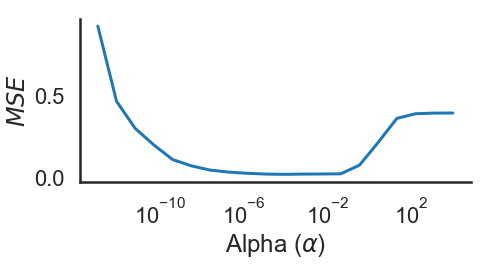

In [28]:
from sklearn import model_selection

# Let's plot the behavior of a fixed degree polynomial
degree = 15
# (i.e., f(x) = w_1*x + w_2*x^2 + ... + w_15*x^15)
# but where we change alpha.
alphas = np.logspace(start=-13,stop=4,num=20)
polynomial_features = PolynomialFeatures(degree=degree,
                                         include_bias=False)
scores = []
for a in alphas:
    linear_regression = Ridge(alpha=a)
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    cv_scores = model_selection.cross_val_score(pipeline,
        X, y, scoring="neg_mean_squared_error", cv=20)
    scores.append(cv_scores)

scores = np.array(scores)

plt.figure(figsize=(7,3))
plt.semilogx(alphas,-np.mean(scores,axis=1),'-')
plt.ylabel('$MSE$')
plt.xlabel('Alpha ($\\alpha$)')
sns.despine()
plt.show()

# What if we have more than one variable?
Let's look at both polynomial degree and regularization weight

In [29]:
scores = []
alphas = np.logspace(start=-13, # Start at 1e-13
                     stop=4,    # Stop at 1e4
                     num=40)    # Split that into 40 pieces
degrees = range(1,16) # This will only go to 15, due to how range works

scores = np.zeros(shape=(len(degrees), # i.e., 15
                         len(alphas))) # i.e., 20

for i, degree in enumerate(degrees): # For each degree
    polynomial_features = PolynomialFeatures(degree=degree,
                                             include_bias=False)
    
    for j,a in enumerate(alphas):    # For each alpha
        linear_regression = Ridge(alpha=a)
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             ("linear_regression", linear_regression)])
        cv_scores = model_selection.cross_val_score(pipeline,
            X, y, scoring="neg_mean_squared_error", cv=20)
        scores[i][j] = -np.mean(cv_scores)


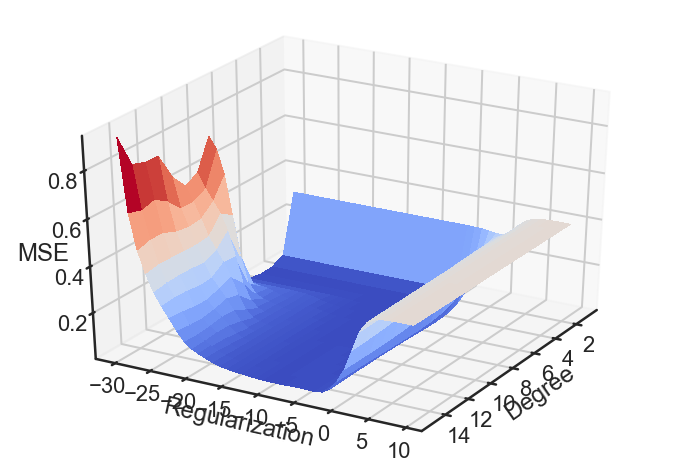

In [30]:
fig = plt.figure(figsize=(10,7))
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
ax = fig.add_subplot(111, projection='3d')

Xs, Ys = np.meshgrid(range(len(degrees)), range(len(alphas)))
zs = np.array([scores[i,j] for i,j in zip(np.ravel(Xs), np.ravel(Ys))])
Zs = zs.reshape(Xs.shape)

Xs, Ys = np.meshgrid(degrees, np.log(alphas))

ax.plot_surface(Xs, Ys, Zs, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)

# Label the Axes
ax.set_xlabel('Degree')
ax.set_ylabel('Regularization')
ax.set_zlabel('MSE')

# Rotate the image
ax.view_init(30, # larger # goes "higher"
             30) # larger # "circles around"
plt.tight_layout()
plt.show()

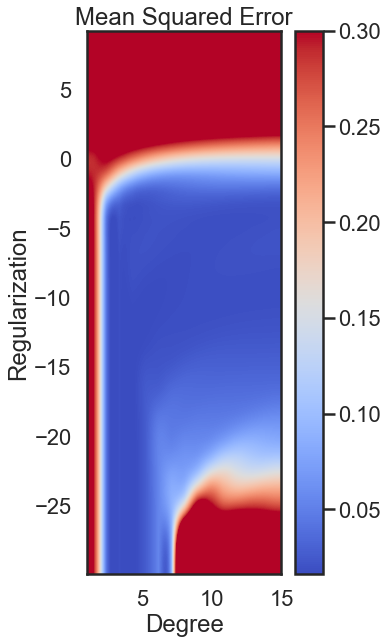

In [31]:
plt.figure(figsize=(5,10))
plt.imshow(Zs,
           cmap=cm.coolwarm, # Allows you to set the color
           vmin=Zs.min(), vmax=0.3, # The min and max Z-Values (for coloring purposes)
           extent=[Xs.min(), Xs.max(),   # How far on X-Axis you want to plot
                   Ys.min(), Ys.max()],  # How far on Y-Axis
           interpolation='spline16',      # How do you want to interpolate values between data?
           origin='lower')
plt.title('Mean Squared Error')
plt.xlabel('Degree')
plt.ylabel('Regularization')
plt.colorbar()

# Optimization
At the end of the day, all this is doing is optimization/search over different parameters.

How should we go about automating this?

Most common: Grid Search.

In [32]:
print('parameters we could change:')
for k in pipeline.get_params().keys():
    print(" ",k)

parameters we could change:
  memory
  steps
  polynomial_features
  linear_regression
  polynomial_features__degree
  polynomial_features__include_bias
  polynomial_features__interaction_only
  linear_regression__alpha
  linear_regression__copy_X
  linear_regression__fit_intercept
  linear_regression__max_iter
  linear_regression__normalize
  linear_regression__random_state
  linear_regression__solver
  linear_regression__tol


In [33]:
from sklearn.model_selection import GridSearchCV
parameters = {'polynomial_features__degree': list(range(1,16)), # 15 possible
              'linear_regression__alpha': np.logspace(start=-13,stop=4,num=10),
              'polynomial_features__include_bias':['True', 'False']}

In [34]:
# How do we want to do cross-validation?
from sklearn import model_selection
num_data_points = len(y)

# 4-fold CV
kfold_cv = model_selection.KFold(n_splits = 4) 

# Or maybe you want randomized splits?
shuffle_cv = model_selection.ShuffleSplit(n_splits = 20,     # How many iterations?
                                          test_size=0.2    # What % should we keep for test?
                                         )

In [35]:
grid_search = GridSearchCV(pipeline,    # The thing we want to optimize
                           parameters,  # The parameters we will change
                           cv=shuffle_cv, # How do you want to cross-validate?
                           scoring = 'neg_mean_squared_error'
                          )
grid_search.fit(X, y) # This runs the cross-validation

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=None, test_size=0.2, train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomial_features', PolynomialFeatures(degree=15, include_bias=False, interaction_only=False)), ('linear_regression', Ridge(alpha=10000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'polynomial_features__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'linear_regression__alpha': array([1.00000e-13, 7.74264e-12, 5.99484e-10, 4.64159e-08, 3.59381e-06,
       2.78256e-04, 2.15443e-02, 1.66810e+00, 1.29155e+02, 1.00000e+04]), 'polynomial_features__include_bias': ['True', 'False']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [36]:
grid_search.best_params_ # Once finished, you can see what the best parameters are

{'linear_regression__alpha': 3.5938136638046257e-06,
 'polynomial_features__degree': 5,
 'polynomial_features__include_bias': 'True'}

In [37]:
print("Best MSE for Grid Search: {:.2e}".format(-grid_search.best_score_))

Best MSE for Grid Search: 1.66e-02


In [38]:
grid_search.predict(X)  # You can also use the best model directly (in sklearn)

array([[ 1.06097211],
       [ 0.97399126],
       [ 0.9385276 ],
       [ 0.85921625],
       [ 0.78547323],
       [-0.20945195],
       [-0.34742376],
       [-0.38613125],
       [-0.4449367 ],
       [-0.54188637],
       [-0.75804255],
       [-0.78001026],
       [-0.82694219],
       [-0.83783579],
       [-0.88728228],
       [-0.95921482],
       [-1.00926296],
       [-1.01455458],
       [-1.01707599],
       [-0.92313959],
       [-0.91783245],
       [-0.89110789],
       [-0.87185274],
       [-0.7708306 ],
       [-0.63240106],
       [-0.54107778],
       [-0.38653015],
       [-0.29425304],
       [-0.19997607],
       [-0.12483163]])

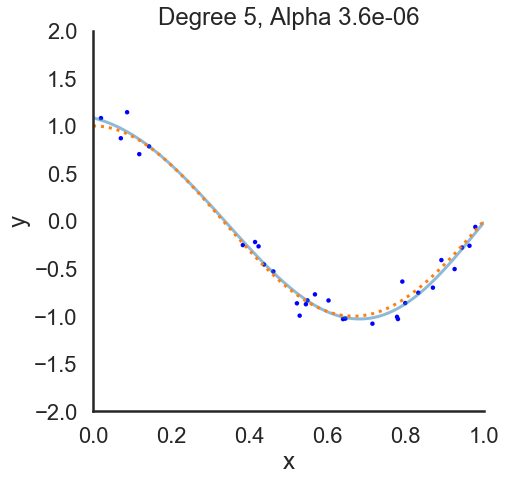

In [39]:
best_degree = grid_search.best_params_['polynomial_features__degree']
best_alpha = grid_search.best_params_['linear_regression__alpha']

plt.figure(figsize=(7, 7))
plt.plot(X_plot, grid_search.predict(X_plot),'-',label="Model",alpha=0.5)
plt.plot(X_plot, true_fun(X_plot), ':',label="True function",alpha=1)
plt.scatter(X,y, c='Blue', s=20, edgecolors='none')
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((0, 1))
plt.ylim((-2, 2))
sns.despine()
plt.title("Degree {}, Alpha {:.1e}".format(best_degree,best_alpha))
plt.show()

# Randomized Search

In reality, grid search is wasteful and not easy to control. A better (and still easy way) is to randomize the search.

In [40]:
# Now, instead of specifying exact which points to test, we instead
# have to specify a distribution to sample from.
# For example, things from http://docs.scipy.org/doc/scipy/reference/stats.html
from scipy.stats import randint as sp_randint
from scipy.stats import lognorm as sp_lognorm

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
parameters = {'polynomial_features__degree': sp_randint(1,20), # We want an integer
              'linear_regression__alpha': sp_lognorm(1),
              'polynomial_features__include_bias':['True', 'False']} # Selecting from two is fine

Need something whose logarithmic distribution we can control. How about a lognormal?
$$
\mathcal{N}(\ln x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left[-\frac {(\ln x - \mu)^2} {2\sigma^2}\right].
$$

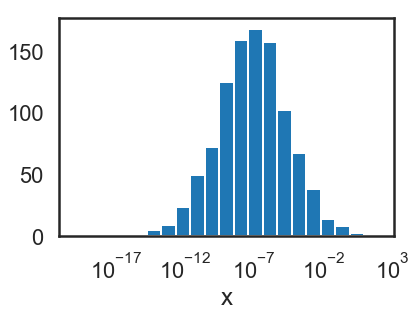

In [41]:
sigma=6
rv = sp_lognorm(sigma,scale=1e-7)

plt.figure()
plt.hist(rv.rvs(size=1000),bins=np.logspace(-20, 2, 22))
plt.xscale('log')
plt.xlabel('x')
plt.show()

In [42]:
parameters = {'polynomial_features__degree': sp_randint(1,20), # We want an integer
              'linear_regression__alpha': sp_lognorm(sigma,scale=1e-7),
              'polynomial_features__include_bias':['True', 'False']} # Selecting from two is fine

In [43]:
# Fitting the high degree polynomial makes the linear system almost
# singular, which makes Numpy issue a Runtime warning.
# This is not a problem here, except that it pops up the warning box
# So I will disable it just for pedagogical purposes
import warnings
warnings.simplefilter('ignore',RuntimeWarning)

# specify parameters and distributions to sample from
from sklearn.model_selection import RandomizedSearchCV

# run randomized search
#n_iter_search = 300 # How many random parameter settings should we try?
n_iter_search = len(grid_search.cv_results_['params']) # Give it same # as grid search, to be fair
random_search = RandomizedSearchCV(pipeline,
                                   param_distributions=parameters,
                                   n_iter=n_iter_search, 
                                   cv=shuffle_cv, # How do you want to cross-validate?
                                   scoring = 'neg_mean_squared_error')
random_search.fit(X, y)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=20, random_state=None, test_size=0.2, train_size=None),
          error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('polynomial_features', PolynomialFeatures(degree=15, include_bias=False, interaction_only=False)), ('linear_regression', Ridge(alpha=10000.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
          fit_params=None, iid='warn', n_iter=300, n_jobs=None,
          param_distributions={'polynomial_features__degree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001976DD30D68>, 'linear_regression__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001976D9FABA8>, 'polynomial_features__include_bias': ['True', 'False']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [44]:
random_search.best_params_ # Once finished, you can see what the best parameters are

{'linear_regression__alpha': 0.00042015290705956784,
 'polynomial_features__degree': 7,
 'polynomial_features__include_bias': 'False'}

In [45]:
print("Best MSE for Random Search: {:.2e}".format(-random_search.best_score_))

Best MSE for Random Search: 1.56e-02


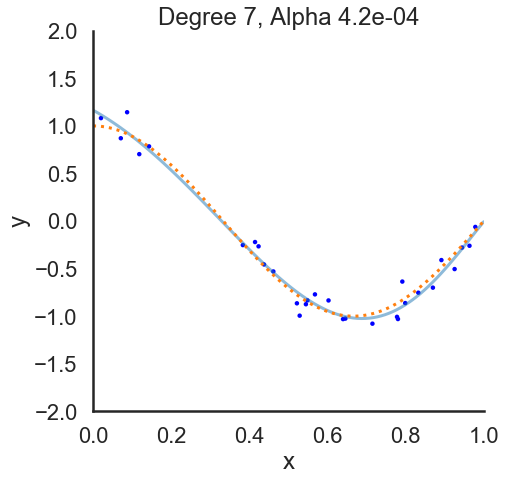

In [46]:
best_degree = random_search.best_params_['polynomial_features__degree']
best_alpha = random_search.best_params_['linear_regression__alpha']

plt.figure(figsize=(7, 7))
plt.plot(X_plot, random_search.predict(X_plot),'-',label="Model",alpha=0.5)
plt.plot(X_plot, true_fun(X_plot), ':',label="True function",alpha=1)
plt.scatter(X,y, c='Blue', s=20, edgecolors='none')
plt.xlabel("x")
plt.ylabel("y")
plt.xlim((0, 1))
plt.ylim((-2, 2))
sns.despine()
plt.title("Degree {}, Alpha {:.1e}".format(best_degree,best_alpha))
plt.show()

# Global Bayesian Optimization

Surely, since we are essentially doing optimization, we could approach hyper-parameter selection as an optimization problem as well, right?

Enter techniques like Global Bayesian Optimization below:

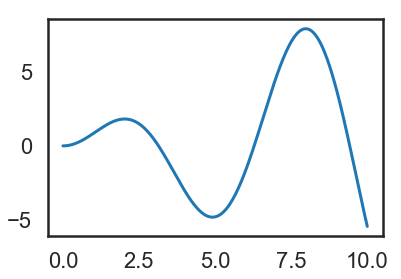

In [47]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)
    # Try others!
    #return 5 * np.sinc(x)
    #return x
    
X = np.atleast_2d(np.linspace(0, 10, 200)).T

# Observations
y = f(X).ravel()

plt.figure()
plt.plot(X,y)
plt.show()

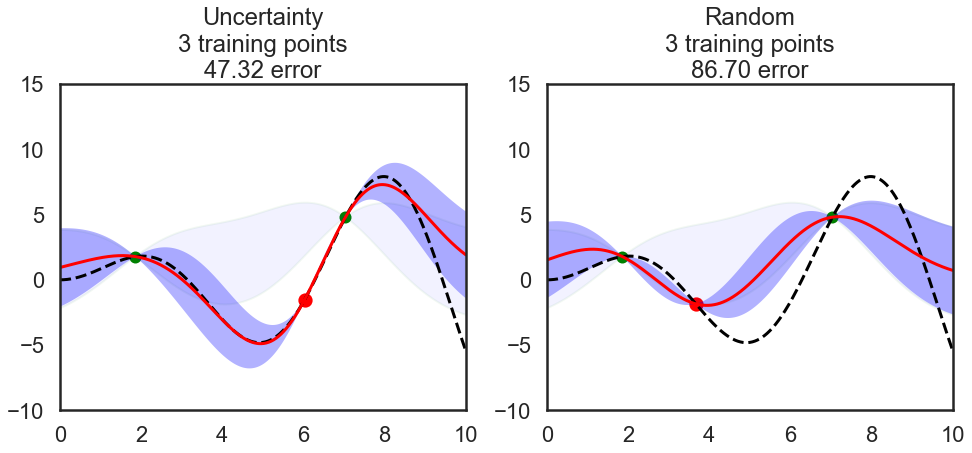

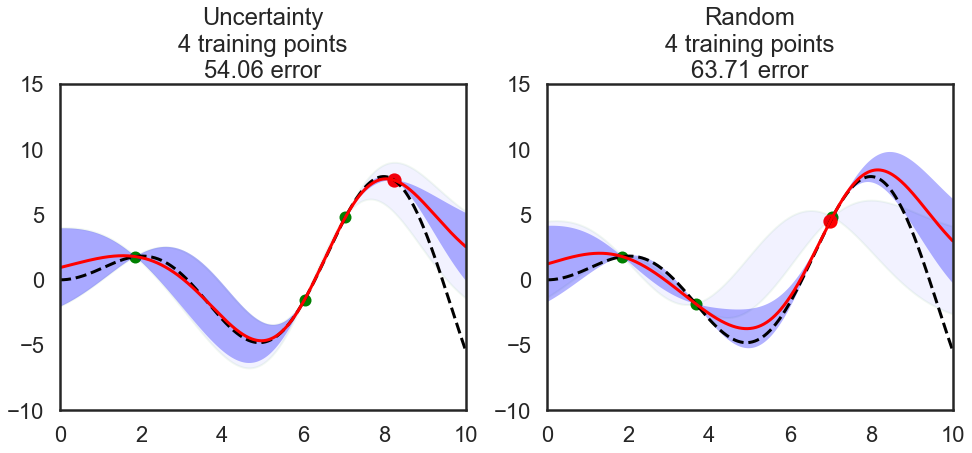

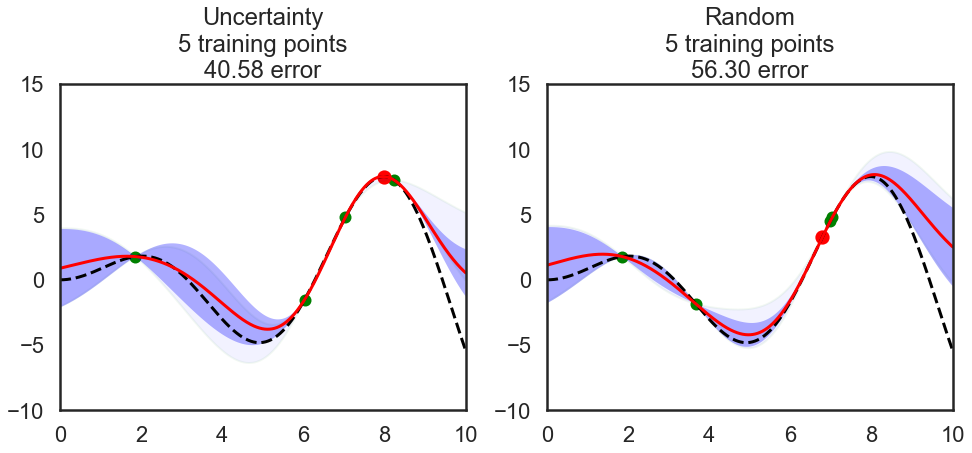

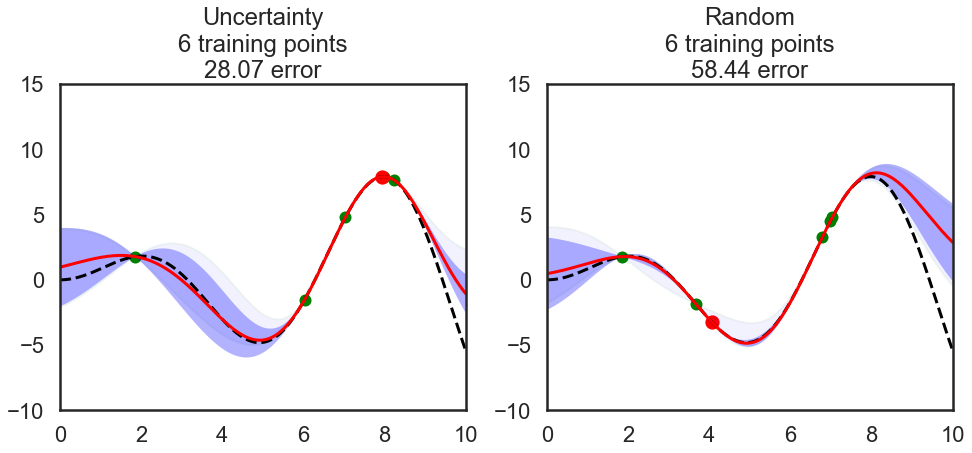

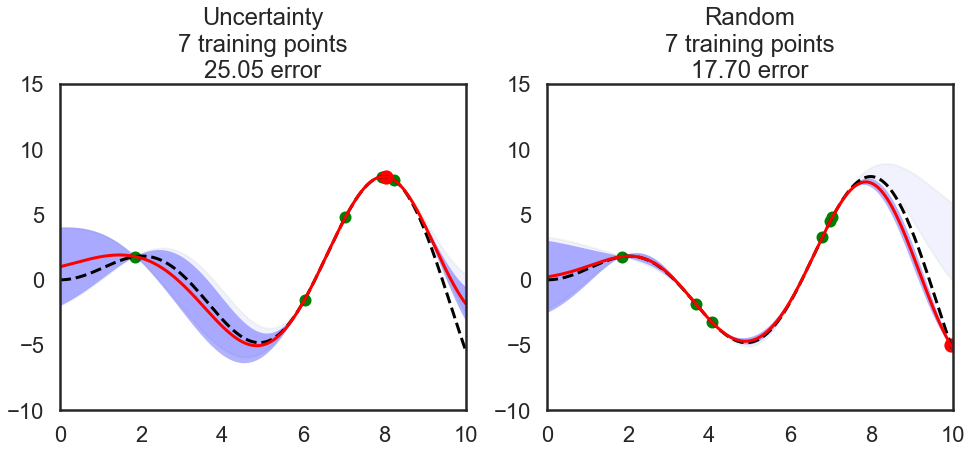

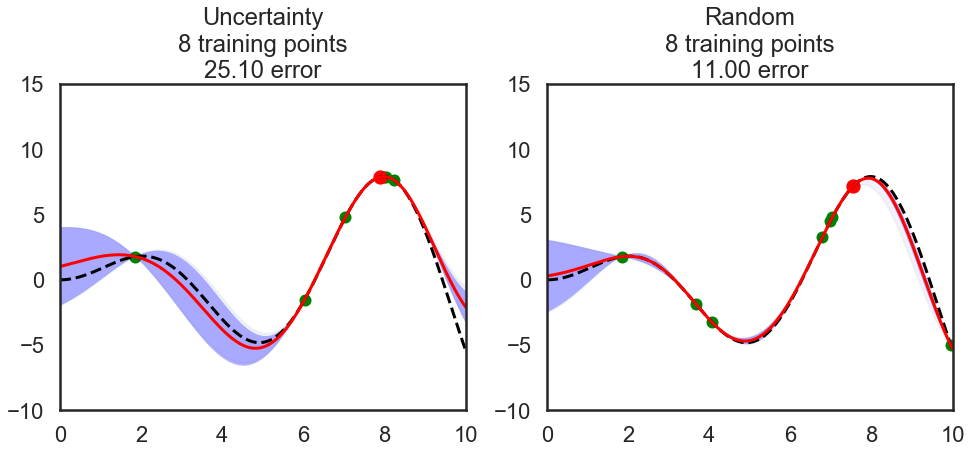

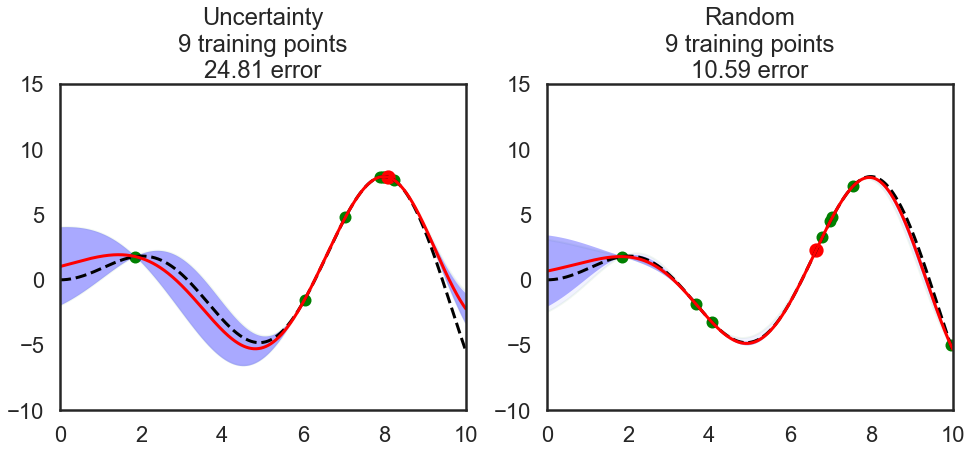

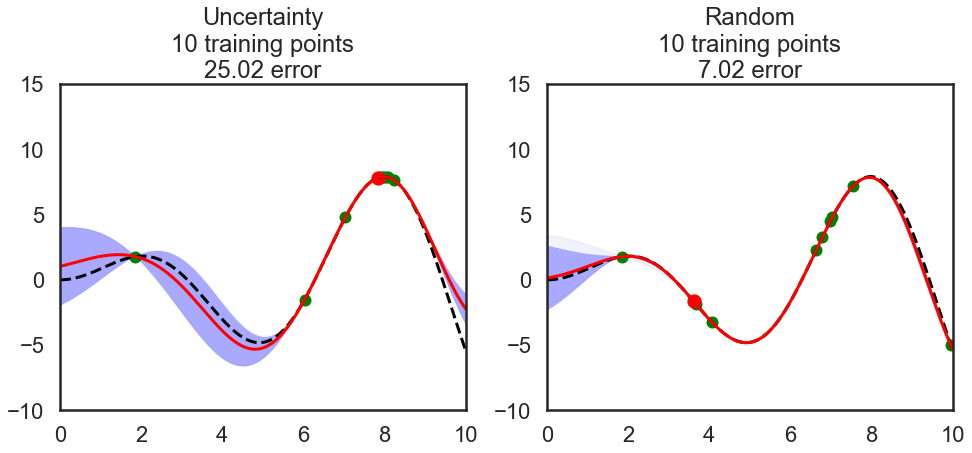

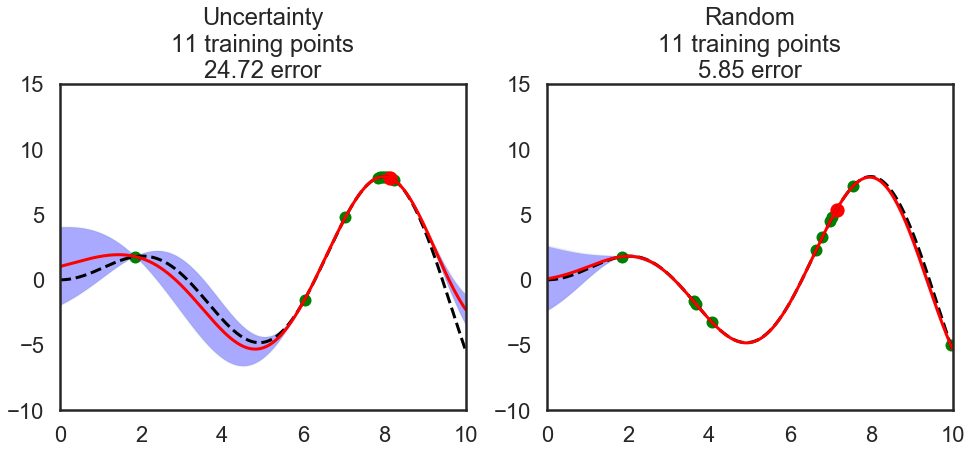

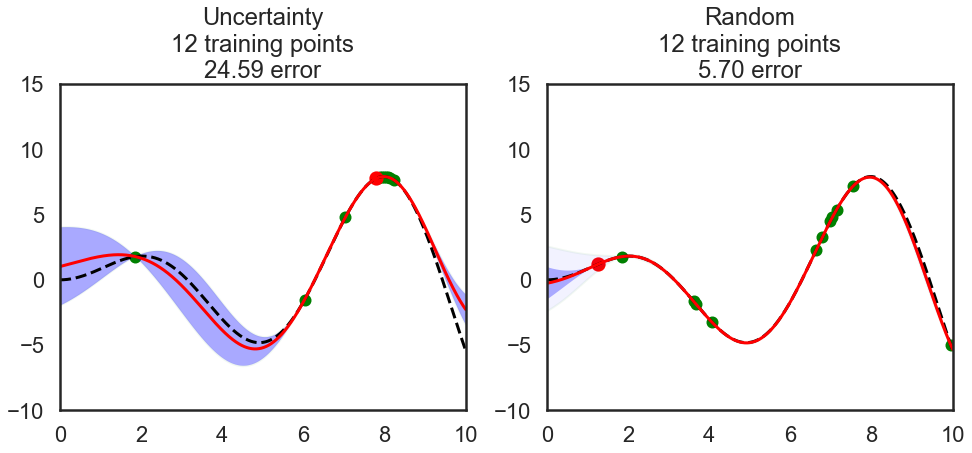

In [48]:
########################################################
# This is just a helper function, no need to worry about
# The internals.
# We will return to this example in Week 14
########################################################
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Create a Gaussian Process model
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
kernel = C(3.0)*RBF(1.5)
gp = GaussianProcessRegressor(kernel=kernel,alpha=1e-6,optimizer=None)
#gp = GaussianProcess(corr='cubic', theta0=1e-2, thetaL=1e-4, thetaU=1e-1,random_start=100)

# Now, ready to begin learning:
train_ind ={
    'Uncertainty':   np.zeros(len(X),dtype=bool),
    'Random':np.zeros(len(X),dtype=bool)
}
options = train_ind.keys()

possible_points = np.array(list(range(len(X))))
# Possible Initialization options
# 1. Select different points randomly
#for i in range(2):
#    for o in options:
#        ind = np.random.choice(possible_points[~train_ind[o]],1)
#        train_ind[o][ind] = True

# 2. Start with end-points
#for o in options:
#    train_ind[o][0] = True
#    train_ind[o][-1] = True

# 3. Start with same random points
for ind in np.random.choice(possible_points,2):
    for o in options:
        train_ind[o][ind] = True

plot_list = np.array([5,10,20,30,40,50,len(X)])
for i in range(10):
    # As i increases, we increase the number of points
    plt.figure(figsize=(16,6))
    for j,o in enumerate(options):
        plt.subplot(1,2,j+1)
        gp.fit(X[train_ind[o],:],y[train_ind[o]])
        yp,sigma = gp.predict(X[~train_ind[o],:], return_std=True)
        ucb = yp + 1.96*sigma
        if o is 'Uncertainty':
            #candidates = np.extract(MSE == np.amax(MSE),X[~train_ind[o],:])
            candidates = np.extract(ucb == np.amax(ucb),X[~train_ind[o],:])
            next_point = np.random.choice(candidates.flatten())
            next_ind = np.argwhere(X.flatten() == next_point)
        elif o is 'Random':
            next_ind = np.random.choice(possible_points[~train_ind[o]],1)
        train_ind[o][next_ind] = True
        
        # Plot intermediate results
        yp,sigma = gp.predict(x, return_std=True)
        plt.fill(np.concatenate([x, x[::-1]]),
                np.concatenate([yp - 1.9600 * sigma,
                               (yp + 1.9600 * sigma)[::-1]]),'b',
                alpha=0.05,  ec='g', label='95% confidence interval')
    
        n_train = np.count_nonzero(train_ind[o])

        gp.fit(X[train_ind[o],:],y[train_ind[o]])
        # Show progress
        yp,sigma = gp.predict(x, return_std=True)
        yt = f(x)
        error = np.linalg.norm(yp-yt.flatten())

        plt.fill(np.concatenate([x, x[::-1]]),
                np.concatenate([yp - 1.9600 * sigma,
                               (yp + 1.9600 * sigma)[::-1]]),'b',
                alpha=0.3,  ec='None', label='95% confidence interval')
        
        plt.plot(x,yt,'k--',alpha=1)
        plt.plot(x,yp,'r-',alpha=1)
        plt.scatter(X[train_ind[o],:],y[train_ind[o]],color='g',s=100)
        plt.scatter(X[next_ind,:].flatten(),y[next_ind].flatten(),color='r',s=150)
        plt.ylim([-10,15])
        plt.xlim([0,10])
        plt.title("%s\n%d training points\n%.2f error"%(o,n_train,error))
    plt.show()

# Hyperband

A more recent technique (March, 2016) called "[Hyperband](https://people.eecs.berkeley.edu/~kjamieson/hyperband.html)" also seems competitive or better than Global Optimization techniques (See [arXiv paper](https://arxiv.org/abs/1603.06560)). In the future I would like to have a visual example of this.

# BOCK

One can also resolve some of the high dimensional problems by modifying the high dimensional space itself. For example in [BOCK : Bayesian Optimization with Cylindrical Kernels](https://arxiv.org/abs/1806.01619) ChangYong Oh, Efstratios Gavves, and Max Welling show how modifying the kernels to be non-stationary enables one to concentrate search on the center sphere of a hypercube, rather than getting stuck in the corners (which is the traditional problem with high dimensional spaces).

# Stochastic Hyperparameter Optimization through Hypernetworks
[This paper](https://arxiv.org/abs/1802.09419) recasts hyper-parameter tuning by directly learning both the hyper-parameters and the optimal weights directly during learning.

# Curse of Dimensionality
Discuss on board examples of the Curse of Dimensionality and how it affects algorithms dependent on calculating distances.

* Space-filling properties of inscribed hyper-cube
* Distance ratio between min and max distances
* Effects on nearest neighbor graphs
* Effects on Gaussian Density

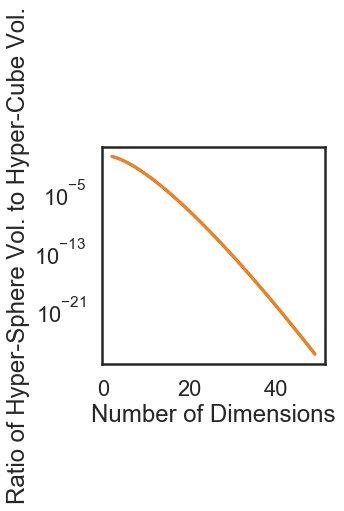

In [49]:
from math import gamma
V_sphere = lambda d: np.pi**(d/2.0)
V_cube = lambda d: d*2**(d-1)*gamma(d/2.0)
volume_ratio = lambda d: V_sphere(d)/V_cube(d)

d = range(2,50)
ratio = [volume_ratio(i) for i in d]
plt.figure(figsize=(4,4))
plt.plot(d,ratio)
plt.semilogy(d,ratio)
plt.ylabel("Ratio of Hyper-Sphere Vol. to Hyper-Cube Vol.")
plt.xlabel("Number of Dimensions")
plt.show()

# TODO: Add distance min/max example